# Clustering EPC data

Copyright 2023 Fulvio Re Cecconi

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License .
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied .
See the License for the specific language governing permissions and
limitations under the License .

**Connect to Google Drive and import Libraries**

In [ ]:
# mount GoogleDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import required libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import scipy
import sklearn.datasets as skd
from sklearn.cluster import BisectingKMeans, KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA

**Read EPC data**

We are working here on a subset of the whole CENED DB (only residendial building permanently used) to save memery and CPU usage


In [ ]:
# define data types to avoid warnings when reading the files
# names of the columns are in Italian
dtypes = {'CODICE_IDENTIFICATIVO_PRATICA':'str', 'DATA_CHIUSURA_PRATICA':'str', 'INDIRIZZO':'str', 'PROVINCIA':'str', 'COMUNE':'str', 'SEZIONE':'str', 'FOGLIO':'str', 'PARTICELLA':'str', 'SUBALTERNO':'str', 'EDIFICIO_PUBBLICO':'str', 'DESTINAZIONE_DI_USO':'str', 'ANNO_COSTRUZIONE':'str', 'MOTIVAZIONE_APE':'str', 'SUPERFICIE_LORDA':'double', 'SUPERFICIE_NETTA':'double', 'VOLUME_LORDO':'double', 'VOLUME_NETTO':'double', 'SUPERFICIE_DISPERDENTE':'double', 'SUPERFICIE_VETRATA_OPACA':'double', 'TRASMITTANZA_MEDIA_INVOLUCRO':'double', 'TRASMITTANZA_MEDIA_COPERTURA':'double', 'TRASMITTANZA_MEDIA_BASAMENTO':'double', 'TRASMITTANZA_MEDIA_SERRAMENTO':'double', 'CLASSE_ENERGETICA':'str', 'EPH':'double', 'ETH':'double', 'ETC':'double', 'EFER':'double', 'EMISSIONI_DI_CO2':'double', 'EPW':'double', 'EPT':'double', 'EF_GLOB_MEDIA_RISCALDAMENTO':'double', 'EF_GLOB_MEDIA_ACQUA_CALDA_SAN':'double', 'EGHW':'double', 'TIPOLOGIA_VENTILAZIONE':'str', 'NUMERO_RICAMBI_ORARI':'str', 'TIPOLOGIA_PANNELLO_ST':'str', 'TIPOLOGIA_PANNELLO_FV':'str', 'SUPERFICIE_CAPTANTE_FV':'str', 'SUPERFICIE_APERTURA_ST':'str', 'SUP_PAN_FV_SUP_UTILE':'str', 'SUP_PAN_ST_SUP_UTILE':'str', 'TIPOLOGIA_COMBUSTIBILE':'str', 'TIPOLOGIA_GENERATORE':'str', 'POTENZA_GENERATORE':'str'}
# read file from google drive and import it in a DataFrame
dfraw = pd.read_csv('/content/drive/MyDrive/2023_EC3_SummerSchoolData/SeparateDS/c1_residential_1.csv', index_col=0, dtype=dtypes)
# show a snapshot of the dataframe
starting_len=len(dfraw)
dfraw.head()

,CODICE_IDENTIFICATIVO_PRATICA,DATA_CHIUSURA_PRATICA,INDIRIZZO,PROVINCIA,COMUNE,SEZIONE,FOGLIO,PARTICELLA,SUBALTERNO,EDIFICIO_PUBBLICO,...,NUMERO_RICAMBI_ORARI,TIPOLOGIA_PANNELLO_ST,TIPOLOGIA_PANNELLO_FV,SUPERFICIE_CAPTANTE_FV,SUPERFICIE_APERTURA_ST,SUP_PAN_FV_SUP_UTILE,SUP_PAN_ST_SUP_UTILE,TIPOLOGIA_COMBUSTIBILE,TIPOLOGIA_GENERATORE,POTENZA_GENERATORE
0,1514601302715,06-MAG-15,VIA PIER DELLA FRANCESCA 38,MI,MILANO,NaN,261,403,17,NO,...,0.5000,NaN,NaN,NaN,NaN,NaN,NaN,Gas naturale,Generatore tradizionale,24.00
1,1514602649910,22-OTT-10,VIA GIOVANNI BELLEZZA 11,MI,MILANO,NaN,527,8,121,NO,...,0.5000,NaN,NaN,NaN,NaN,NaN,NaN,Gas naturale,Generatore ACS|Generatore a condensazione,4.63
2,1703800022511,27-OTT-11,"VIA PALAZZOLO, 41",BS,CAPRIOLO,NCT,20,217,4|5,NO,...,0.3000|0.3000,NaN,NaN,NaN,NaN,NaN,NaN,Gas naturale,Generatore tradizionale,66.90
3,1708500008614,25-MAR-14,"VICOLO DELLE PORTELLE, 23",BS,ISEO,NCT,24,103,14,NO,...,0.5000,NaN,NaN,NaN,NaN,NaN,NaN,Gas naturale,Generatore multistadio o modulante,26.30
4,1601600016310,03-DIC-10,VIA VITTORIO ALFIERI 3,BG,AZZANO SAN PAOLO,NaN,6,1384,3,NO,...,0.5000,Collettori piani vetrati,NaN,NaN,4.0400,NaN,1.000,Gas naturale,Generatore a condensazione multistadio o modul...,35.43


In [ ]:
# create a unique ID to remove duplicates
dfraw['UNIQUE_ID']=dfraw['COMUNE']+dfraw['FOGLIO']+dfraw['PARTICELLA']+dfraw['SUBALTERNO']
print('There are', len(dfraw[dfraw.duplicated(subset=['UNIQUE_ID'])]), 'duplicates')
# remove duplicates
dfraw=dfraw.drop_duplicates(subset=['UNIQUE_ID'], keep='last')
# drop the UNIQUE_ID
dfraw=dfraw.drop(['UNIQUE_ID'], axis=1)
print('There are', len(dfraw),'records left')

There are 50376 duplicates
There are 1116274 records left


In [ ]:
# create a new DataFrame using only the column I want to focus on
# 'ANNO_COSTRUZIONE' year of construction
# 'VOLUME_LORDO' gross volume
# 'SUPERFICIE_DISPERDENTE' gross anvelope surface
# 'SUPERFICIE_VETRATA_OPACA' ratio between windows and walls surface
# 'TRASMITTANZA_MEDIA_INVOLUCRO' average walls transmittance
# 'TRASMITTANZA_MEDIA_COPERTURA' average roofs transmittance
# 'TRASMITTANZA_MEDIA_SERRAMENTO' average windows transmittance
# 'EPH' energy demand
df = dfraw[['ANNO_COSTRUZIONE', 'VOLUME_LORDO', 'SUPERFICIE_DISPERDENTE', 'SUPERFICIE_VETRATA_OPACA', 'TRASMITTANZA_MEDIA_INVOLUCRO', 'TRASMITTANZA_MEDIA_COPERTURA', 'TRASMITTANZA_MEDIA_SERRAMENTO', 'EPH']]

In [ ]:
# get some info anout the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1116274 entries, 0 to 1516482
Data columns (total 8 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   ANNO_COSTRUZIONE               1116250 non-null  object 
 1   VOLUME_LORDO                   1116274 non-null  float64
 2   SUPERFICIE_DISPERDENTE         1116274 non-null  float64
 3   SUPERFICIE_VETRATA_OPACA       1116274 non-null  float64
 4   TRASMITTANZA_MEDIA_INVOLUCRO   1116274 non-null  float64
 5   TRASMITTANZA_MEDIA_COPERTURA   575977 non-null   float64
 6   TRASMITTANZA_MEDIA_SERRAMENTO  1116274 non-null  float64
 7   EPH                            1116274 non-null  float64
dtypes: float64(7), object(1)
memory usage: 76.6+ MB


In [ ]:
# delete records with missing data
vol_start = len(df)
print('Starting with',vol_start, 'records')
df.dropna(inplace=True)
vol_end = len(df)
print('Ending with',vol_end, 'records')
print('Deleted', vol_start-vol_end, 'records out of', vol_start, 'equal to',round((vol_end-vol_start)/vol_start*100,2),'%')

Starting with 1116274 records
Ending with 575967 records
Deleted 540307 records out of 1116274 equal to -48.4 %


<ipython-input-7-bf0819ab2d58>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [ ]:
# The year of construction is stored either as a number (memorised as a string) or as a string.
# We need to convert both the values in a number according to these rules
# built before 1930 -> 1
# built between 1930 and 1945 -> 2
# built between 1946 and 1960 -> 3
# built between 1961 and 1976 -> 3
# bullt between 1977 and 1992 -> 5
# built between 1993 and 2006 -> 6
# built after 2006 -> 7

# here are the functions to be used:
def process_value(value):
    if isinstance(value, float):
        return substitute_number(value)
    elif isinstance(value, str):
        if value.isdigit():
            return substitute_number(int(value))
        else:
            return substitute_string(value)
    else:
        return -1

def substitute_number(number_year):
    if number_year > 2006: return 7;
    elif number_year >=1993: return 6;
    elif number_year >=1977: return 5;
    elif number_year >=1961: return 4;
    elif number_year >=1946: return 3;
    elif number_year >=1930: return 2;
    elif number_year <1930: return 1;
    else: return -1

def substitute_string(string_year):
    if string_year == 'prima del 1930': return 1;
    elif string_year == '1930-1945': return 2;
    elif string_year == '1946-1960': return 3;
    elif string_year == '1961-1976': return 4;
    elif string_year == '1977-1992': return 5;
    elif string_year == '1993-2006': return 6;
    elif string_year == 'dopo il 2006': return 7;
    else: return -1


def check_and_substitute(df, column_name):
    df['ANNO_COSTRUZIONE'] = df[column_name].apply(process_value)
    return df


In [ ]:
# Convert the year of construction
check_and_substitute(df,'ANNO_COSTRUZIONE')
df.head()

<ipython-input-8-f1ae8e73d7b4>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ANNO_COSTRUZIONE'] = df[column_name].apply(process_value)


,ANNO_COSTRUZIONE,VOLUME_LORDO,SUPERFICIE_DISPERDENTE,SUPERFICIE_VETRATA_OPACA,TRASMITTANZA_MEDIA_INVOLUCRO,TRASMITTANZA_MEDIA_COPERTURA,TRASMITTANZA_MEDIA_SERRAMENTO,EPH
2,4,1505.0060,1045.110,0.0782,1.3136,1.6051,1.7659,249.7610
4,4,578.3110,392.360,0.0687,1.0000,0.2350,1.8493,60.5945
5,1,268.9700,130.140,0.0711,2.4856,1.3600,4.7781,500.8298
6,4,398.6100,267.040,0.1306,1.6774,1.3000,1.5696,298.6695
8,7,123.7432,74.378,0.1003,0.3541,0.2080,1.3912,57.5989


In [ ]:
# remove records with errors (-1) in the year of construction
vol_start = len(df)
print('Starting with',vol_start, 'records')
df.drop(df[(df.ANNO_COSTRUZIONE == -1 )].index, inplace=True)
vol_end = len(df)
print('Ending with',vol_end, 'records')
print('Deleted', vol_start-vol_end, 'records out of', vol_start, 'equal to',round((vol_end-vol_start)/vol_start*100,2),'%')
# remove records with errors (negative values) in the transmittance of windows
vol_start = len(df)
print('Starting with',vol_start, 'records')
df.drop(df[(df.TRASMITTANZA_MEDIA_SERRAMENTO <= 0)].index, inplace=True)
vol_end = len(df)
print('Ending with',vol_end, 'records')
print('Deleted', vol_start-vol_end, 'records out of', vol_start, 'equal to',round((vol_end-vol_start)/vol_start*100,2),'%')
# remove records with errors (too high values) in the transmittance of windows
vol_start = len(df)
print('Starting with',vol_start, 'records')
df.drop(df[(df.TRASMITTANZA_MEDIA_SERRAMENTO > 15)].index, inplace=True)
vol_end = len(df)
print('Ending with',vol_end, 'records')
print('Deleted', vol_start-vol_end, 'records out of', vol_start, 'equal to',round((vol_end-vol_start)/vol_start*100,2),'%')
# remove records with errors (too high values) in the transmittance of walls
vol_start = len(df)
print('Starting with',vol_start, 'records')
df.drop(df[(df.TRASMITTANZA_MEDIA_INVOLUCRO > 10)].index, inplace=True)
vol_end = len(df)
print('Ending with',vol_end, 'records')
print('Deleted', vol_start-vol_end, 'records out of', vol_start, 'equal to',round((vol_end-vol_start)/vol_start*100,2),'%')
# remove records with errors (too high values) in the gross volume
vol_start = len(df)
print('Starting with',vol_start, 'records')
df.drop(df[(df.VOLUME_LORDO >= 6000)].index, inplace=True)
vol_end = len(df)
print('Ending with',vol_end, 'records')
print('Deleted', vol_start-vol_end, 'records out of', vol_start, 'equal to',round((vol_end-vol_start)/vol_start*100,2),'%')
# remove records with errors (too high values) in the EPH
vol_start = len(df)
print('Starting with',vol_start, 'records')
df.drop(df[(df.EPH >= 1000)].index, inplace=True)
vol_end = len(df)
print('Ending with',vol_end, 'records')
print('Deleted', vol_start-vol_end, 'records out of', vol_start, 'equal to',round((vol_end-vol_start)/vol_start*100,2),'%')

<ipython-input-10-51620b0fcfa4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[(df.ANNO_COSTRUZIONE == -1 )].index, inplace=True)
<ipython-input-10-51620b0fcfa4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[(df.TRASMITTANZA_MEDIA_SERRAMENTO <= 0)].index, inplace=True)


Starting with 575967 records
Ending with 575966 records
Deleted 1 records out of 575967 equal to -0.0 %
Starting with 575966 records
Ending with 571810 records
Deleted 4156 records out of 575966 equal to -0.72 %
Starting with 571810 records


<ipython-input-10-51620b0fcfa4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[(df.TRASMITTANZA_MEDIA_SERRAMENTO > 15)].index, inplace=True)
<ipython-input-10-51620b0fcfa4>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[(df.TRASMITTANZA_MEDIA_INVOLUCRO > 10)].index, inplace=True)


Ending with 571790 records
Deleted 20 records out of 571810 equal to -0.0 %
Starting with 571790 records
Ending with 571789 records
Deleted 1 records out of 571790 equal to -0.0 %
Starting with 571789 records
Ending with 565090 records
Deleted 6699 records out of 571789 equal to -1.17 %
Starting with 565090 records
Ending with 564599 records
Deleted 491 records out of 565090 equal to -0.09 %


<ipython-input-10-51620b0fcfa4>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[(df.VOLUME_LORDO >= 6000)].index, inplace=True)
<ipython-input-10-51620b0fcfa4>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[(df.EPH >= 1000)].index, inplace=True)


In [ ]:
# gross cleaning results
print(' We started with', starting_len, 'records and we end up with', vol_end, 'records, deleting', np.round((starting_len-vol_end)/starting_len*100,2), '% of the records')

 We started with 1166650 records and we end up with 564599 records, deleting 51.61 % of the records


In [ ]:
df.describe()

,ANNO_COSTRUZIONE,VOLUME_LORDO,SUPERFICIE_DISPERDENTE,SUPERFICIE_VETRATA_OPACA,TRASMITTANZA_MEDIA_INVOLUCRO,TRASMITTANZA_MEDIA_COPERTURA,TRASMITTANZA_MEDIA_SERRAMENTO,EPH
count,564599.000000,564599.000000,564599.000000,564599.000000,564599.000000,564599.000000,564599.000000,564599.000000
mean,4.388989,466.865099,297.461596,0.073110,0.997623,0.953435,3.094504,219.512858
std,1.873531,566.187637,283.657611,0.066202,0.515496,0.547230,1.079182,132.510843
min,1.000000,0.703900,7.590000,0.000700,0.000000,0.001000,0.001000,0.000000
25%,3.000000,235.000000,154.520000,0.050200,0.587800,0.475250,2.258100,120.565550
50%,4.000000,333.350000,223.555000,0.065100,1.033400,0.860000,3.231800,199.167500
75%,6.000000,488.900000,340.560000,0.084100,1.364100,1.400000,3.481800,299.250750
max,7.000000,5999.660000,7538.970000,15.086100,5.848000,7.143000,14.921800,998.148700


**Clustering**

In [ ]:
# We're not going to clusterize the energy demand
data = df[['ANNO_COSTRUZIONE', 'VOLUME_LORDO', 'SUPERFICIE_DISPERDENTE', 'SUPERFICIE_VETRATA_OPACA', 'TRASMITTANZA_MEDIA_INVOLUCRO', 'TRASMITTANZA_MEDIA_COPERTURA', 'TRASMITTANZA_MEDIA_SERRAMENTO']].to_numpy()

K-Means

In [ ]:
# clusterizing parameters
n_clusters = 6
random_state = 0
# clusterization
kmeans = KMeans(n_clusters=n_clusters, init="random", random_state=random_state, n_init="auto")
kmeans.fit(data)
# savings results
centers = kmeans.cluster_centers_
kmeans_labels = kmeans.labels_

In [ ]:
# saved clustering info in a DataFrame
df_kmeans = df.copy(deep=True)
df_kmeans['CLUSTER'] = kmeans_labels
print('The total number of clusters found using K Means is:',np.max(kmeans_labels)+1)

The total number of clusters found using K Means is: 6


In [ ]:
# count the number of elements in each cluster
for cluster in range(np.max(kmeans_labels)+1):
  print('Cluster', cluster, 'has', len(df_kmeans[(df_kmeans.CLUSTER == cluster)]), 'records')

Cluster 0 has 59460 records
Cluster 1 has 4520 records
Cluster 2 has 184684 records
Cluster 3 has 298433 records
Cluster 4 has 6031 records
Cluster 5 has 11471 records


In [ ]:
# prepare the data for the plot
x=[]
for cluster in range(np.max(kmeans_labels)+1):
  x.append(np.array(df_kmeans[(df_kmeans.CLUSTER == cluster)].drop(['CLUSTER'],axis=1).mean()))
# convert the data into a numpy array
ys=np.array(x)

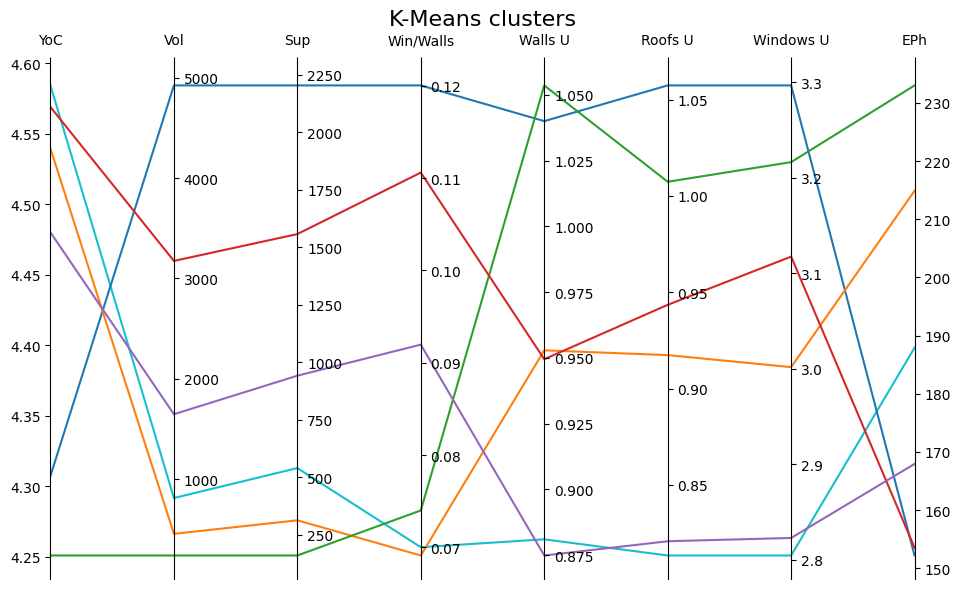

In [ ]:
# graph the mean of the clusters

# create the canvas for the plot
resolution = 100
figure_size = 6
fig, host = plt.subplots(figsize=(figure_size * 1.618, figure_size))

# names for the axis
ynames = ['YoC', 'Vol', 'Sup', 'Win/Walls','Walls U', 'Roofs U', 'Windows U', 'EPh']

# category to assign colors
category = range(ys.shape[0])

# organize the data
ymins = ys.min(axis=0)
ymaxs = ys.max(axis=0)
dys = ymaxs - ymins
ymins -= dys * 0.05  # add 5% padding below and above
ymaxs += dys * 0.05
dys = ymaxs - ymins

# transform all data to be compatible with the main axis
zs = np.zeros_like(ys)
zs[:, 0] = ys[:, 0]
zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]


axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))

host.set_xlim(0, ys.shape[1] - 1)
host.set_xticks(range(ys.shape[1]))
host.set_xticklabels(ynames, fontsize=10)
host.tick_params(axis='x', which='major', pad=7)
host.spines['right'].set_visible(False)
host.xaxis.tick_top()
host.set_title('K-Means clusters', fontsize=16)

colors = plt.cm.tab10.colors
for j in range(len(category)):
    host.plot(range(ys.shape[1]), zs[j,:], c=colors[(category[j] - 1) % len(colors) ])
plt.tight_layout()
plt.show()

Bisecting K-Means

In [ ]:
# clusterizing parameters
n_clusters = 6
random_state = 0
# clusterization
bkm = BisectingKMeans(n_clusters=n_clusters, init="random", random_state=random_state, n_init=3)
bkm.fit(data)
# savings results
centers = bkm.cluster_centers_
bkm_labels = bkm.labels_

In [ ]:
# saved clustering info in a DataFrame
df_bkm = df.copy(deep=True)
df_bkm['CLUSTER'] = bkm_labels
print('The total number of clusters found using bisecating K Means is:',np.max(bkm_labels)+1)

The total number of clusters found using bisecating K Means is: 6


In [ ]:
# count the number of elements in each cluster
for cluster in range(np.max(bkm_labels)+1):
  print('Cluster', cluster, 'has', len(df_bkm[(df_bkm.CLUSTER == cluster)]), 'records')

Cluster 0 has 5548 records
Cluster 1 has 7542 records
Cluster 2 has 17677 records
Cluster 3 has 77742 records
Cluster 4 has 188799 records
Cluster 5 has 267291 records


In [ ]:
# prepare the data for the plot
x=[]
for cluster in range(np.max(bkm_labels)+1):
  x.append(np.array(df_bkm[(df_bkm.CLUSTER == cluster)].drop(['CLUSTER'],axis=1).mean()))
# convert the data into a numpy array
ys=np.array(x)

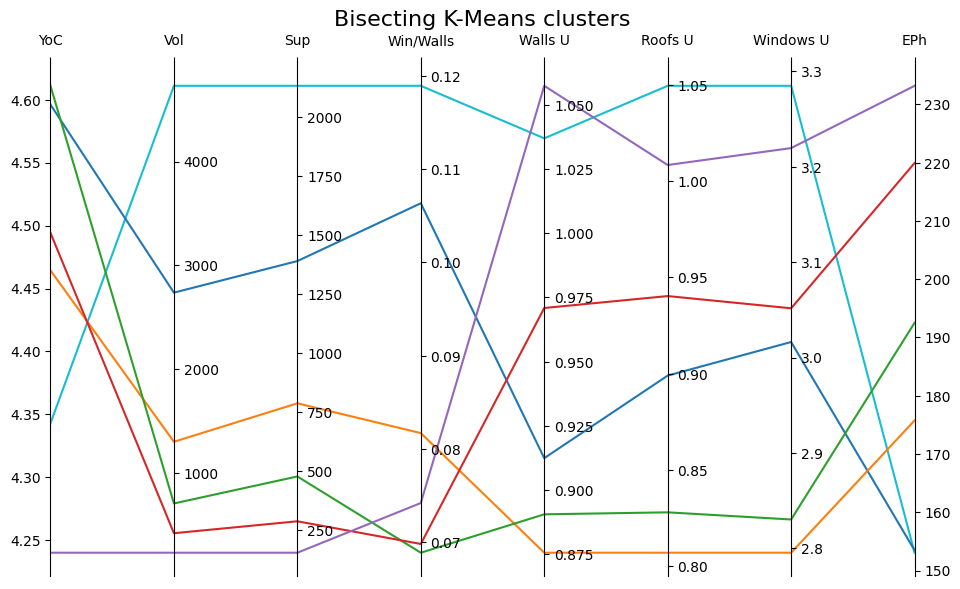

In [ ]:
# graph the mean of the clusters

# create the canvas for the plot
resolution = 100
figure_size = 6
fig, host = plt.subplots(figsize=(figure_size * 1.618, figure_size))

# names for the axis
ynames = ['YoC', 'Vol', 'Sup', 'Win/Walls','Walls U', 'Roofs U', 'Windows U', 'EPh']

# category to assign colors
category = range(ys.shape[0])

# organize the data
ymins = ys.min(axis=0)
ymaxs = ys.max(axis=0)
dys = ymaxs - ymins
ymins -= dys * 0.05  # add 5% padding below and above
ymaxs += dys * 0.05
dys = ymaxs - ymins

# transform all data to be compatible with the main axis
zs = np.zeros_like(ys)
zs[:, 0] = ys[:, 0]
zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]


axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))

host.set_xlim(0, ys.shape[1] - 1)
host.set_xticks(range(ys.shape[1]))
host.set_xticklabels(ynames, fontsize=10)
host.tick_params(axis='x', which='major', pad=7)
host.spines['right'].set_visible(False)
host.xaxis.tick_top()
host.set_title('Bisecting K-Means clusters', fontsize=16)

colors = plt.cm.tab10.colors
for j in range(len(category)):
    host.plot(range(ys.shape[1]), zs[j,:], c=colors[(category[j] - 1) % len(colors) ])
plt.tight_layout()
plt.show()

DB SCAN

In [ ]:
# clustering
db = DBSCAN(eps=0.3, min_samples=10).fit(data)
# savings results
dbs_labels = db.labels_

In [ ]:
# saved clustering info in a DataFrame
df_dbscan = df.copy(deep=True)
df_dbscan['CLUSTER'] = dbs_labels
print('The total number of clusters found using K Means is:',np.max(dbs_labels)+1)

The total number of clusters found using K Means is: 34


In [ ]:
# count the number of elements in each cluster
for cluster in range(np.max(dbs_labels)):
  print('Cluster', cluster, 'has', len(df_dbscan[(df_dbscan.CLUSTER == cluster)]), 'records')

Cluster 0 has 12 records
Cluster 1 has 16 records
Cluster 2 has 13 records
Cluster 3 has 12 records
Cluster 4 has 27 records
Cluster 5 has 11 records
Cluster 6 has 27 records
Cluster 7 has 16 records
Cluster 8 has 16 records
Cluster 9 has 24 records
Cluster 10 has 16 records
Cluster 11 has 33 records
Cluster 12 has 19 records
Cluster 13 has 11 records
Cluster 14 has 10 records
Cluster 15 has 12 records
Cluster 16 has 12 records
Cluster 17 has 24 records
Cluster 18 has 10 records
Cluster 19 has 12 records
Cluster 20 has 16 records
Cluster 21 has 11 records
Cluster 22 has 16 records
Cluster 23 has 10 records
Cluster 24 has 10 records
Cluster 25 has 18 records
Cluster 26 has 13 records
Cluster 27 has 11 records
Cluster 28 has 10 records
Cluster 29 has 11 records
Cluster 30 has 12 records
Cluster 31 has 14 records
Cluster 32 has 10 records


In [ ]:
# prepare the data for the plot
x=[]
for cluster in range(np.max(dbs_labels)):
  x.append(np.array(df_dbscan[(df_dbscan.CLUSTER == cluster)].drop(['CLUSTER'],axis=1).mean()))
# convert the data into a numpy array
ys=np.array(x)
ys.shape

(33, 8)

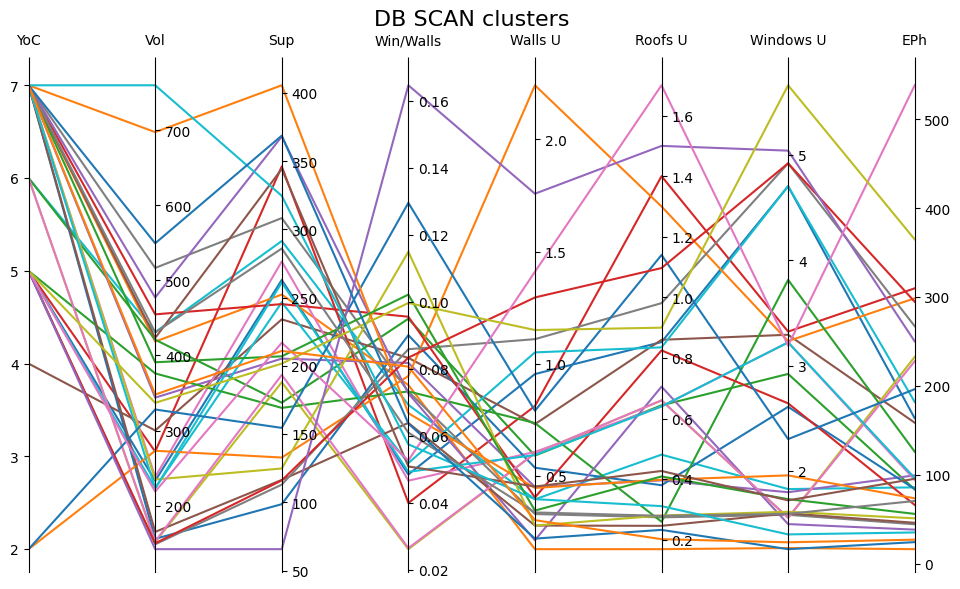

In [ ]:
# graph the mean of the clusters

# create the canvas for the plot
resolution = 100
figure_size = 6
fig, host = plt.subplots(figsize=(figure_size * 1.618, figure_size))

# names for the axis
ynames = ['YoC', 'Vol', 'Sup', 'Win/Walls','Walls U', 'Roofs U', 'Windows U', 'EPh']

# category to assign colors
category = range(ys.shape[0])

# organize the data
ymins = ys.min(axis=0)
ymaxs = ys.max(axis=0)
dys = ymaxs - ymins
ymins -= dys * 0.05  # add 5% padding below and above
ymaxs += dys * 0.05
dys = ymaxs - ymins

# transform all data to be compatible with the main axis
zs = np.zeros_like(ys)
zs[:, 0] = ys[:, 0]
zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]


axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))

host.set_xlim(0, ys.shape[1] - 1)
host.set_xticks(range(ys.shape[1]))
host.set_xticklabels(ynames, fontsize=10)
host.tick_params(axis='x', which='major', pad=7)
host.spines['right'].set_visible(False)
host.xaxis.tick_top()
host.set_title('DB SCAN clusters', fontsize=16)

colors = plt.cm.tab10.colors
for j in range(len(category)):
    host.plot(range(ys.shape[1]), zs[j,:], c=colors[(category[j] - 1) % len(colors) ])
plt.tight_layout()
plt.show()

# Principal Components Analysis

In [ ]:
#normalise the data
x = StandardScaler().fit_transform(df.to_numpy())
# convert the numpy array back to a pandas dataframe
normalised_data=pd.DataFrame(x,columns=['ANNO_COSTRUZIONE', 'VOLUME_LORDO', 'SUPERFICIE_DISPERDENTE', 'SUPERFICIE_VETRATA_OPACA', 'TRASMITTANZA_MEDIA_INVOLUCRO', 'TRASMITTANZA_MEDIA_COPERTURA', 'TRASMITTANZA_MEDIA_SERRAMENTO', 'EPH'])
normalised_data.head()

,ANNO_COSTRUZIONE,VOLUME_LORDO,SUPERFICIE_DISPERDENTE,SUPERFICIE_VETRATA_OPACA,TRASMITTANZA_MEDIA_INVOLUCRO,TRASMITTANZA_MEDIA_COPERTURA,TRASMITTANZA_MEDIA_SERRAMENTO,EPH
0,-0.207624,1.833565,2.635745,0.076893,0.612957,1.190844,-1.231122,0.228269
1,-0.207624,0.196836,0.334553,-0.066609,0.004610,-1.312859,-1.153842,-1.199287
2,-1.808880,-0.349522,-0.589872,-0.030356,2.886498,0.742952,1.560067,2.122975
3,-0.207624,-0.120552,-0.107248,0.868416,1.318686,0.633308,-1.413020,0.597360
4,1.393632,-0.606022,-0.786454,0.410722,-1.248359,-1.362199,-1.578330,-1.221893


In [ ]:
# make the PCA
pca_epc = PCA(n_components=2)
principalComponents = pca_epc.fit_transform(x)
# show how each component explain of the variance ratio
print('Explained variation per principal component: {}'.format(pca_epc.explained_variance_ratio_))

Explained variation per principal component: [0.40833977 0.23812856]


K Means clusters

In [ ]:
# transorming the principal components back into a dataframe
principal_kmeans_Df = pd.DataFrame(data = principalComponents
             , columns = ['PC 1', 'PC 2'])
# adding cluster labels
principal_kmeans_Df['CLUSTER']=kmeans_labels

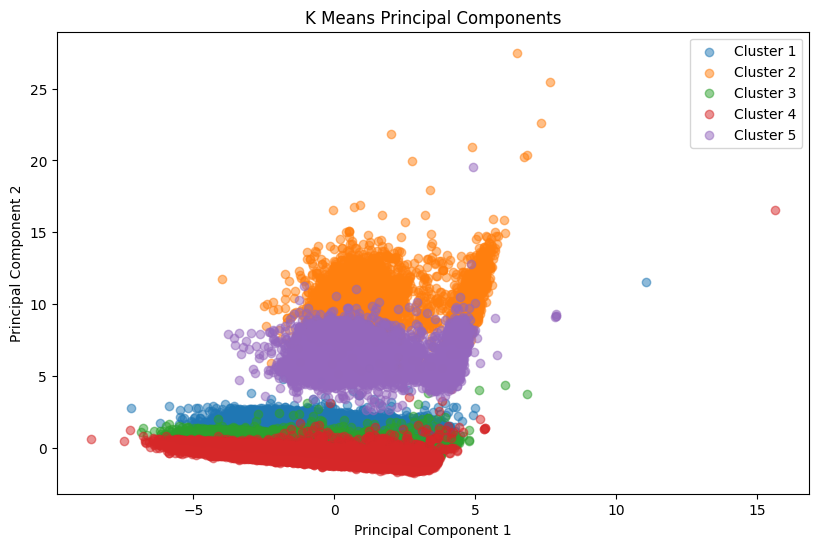

In [ ]:
# Plotting the two PC
# create the canvas for the plot
resolution = 100
figure_size = 6
fig = plt.figure(dpi=resolution, figsize=(figure_size * 1.618, figure_size))

# choose a color scheme
colors = plt.cm.tab10.colors
# plot the separated cluster
for j in range(np.max(kmeans_labels)):
  plt.scatter(principal_kmeans_Df[(principal_kmeans_Df['CLUSTER']==j)].drop(['PC 2','CLUSTER'], axis=1).to_numpy(),
              principal_kmeans_Df[(principal_kmeans_Df['CLUSTER']==j)].drop(['PC 1','CLUSTER'], axis=1).to_numpy(),
              color=colors[j % len(colors) ], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K Means Principal Components')
plt.legend(["Cluster " + str(x+1) for x in range(np.max(kmeans_labels))])
plt.show()

Bisecant K Means

In [ ]:
# transorming the principal components back into a dataframe
principal_bkm_Df = pd.DataFrame(data = principalComponents
             , columns = ['PC 1', 'PC 2'])
# adding cluster labels
principal_bkm_Df['CLUSTER']=bkm_labels

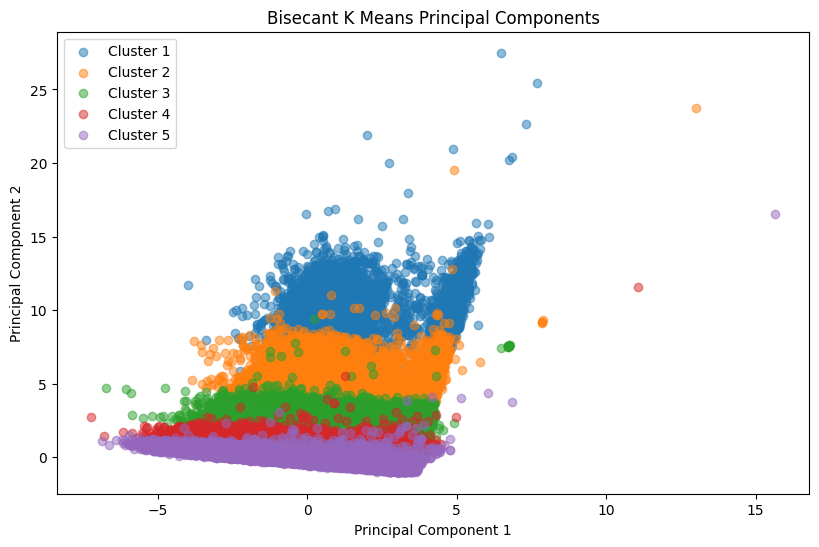

In [ ]:
# Plotting the two PC
# create the canvas for the plot
resolution = 100
figure_size = 6
fig = plt.figure(dpi=resolution, figsize=(figure_size * 1.618, figure_size))

# choose a color scheme
colors = plt.cm.tab10.colors
# plot the separated cluster
for j in range(np.max(bkm_labels)):
  plt.scatter(principal_bkm_Df[(principal_bkm_Df['CLUSTER']==j)].drop(['PC 2','CLUSTER'], axis=1).to_numpy(),
              principal_bkm_Df[(principal_bkm_Df['CLUSTER']==j)].drop(['PC 1','CLUSTER'], axis=1).to_numpy(),
              color=colors[j % len(colors) ], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Bisecant K Means Principal Components')
plt.legend(["Cluster " + str(x+1) for x in range(np.max(bkm_labels))])
plt.show()

DB SCAN

In [ ]:
# transorming the principal components back into a dataframe
principal_dbs_Df = pd.DataFrame(data = principalComponents
             , columns = ['PC 1', 'PC 2'])
# adding cluster labels
principal_dbs_Df['CLUSTER']=dbs_labels

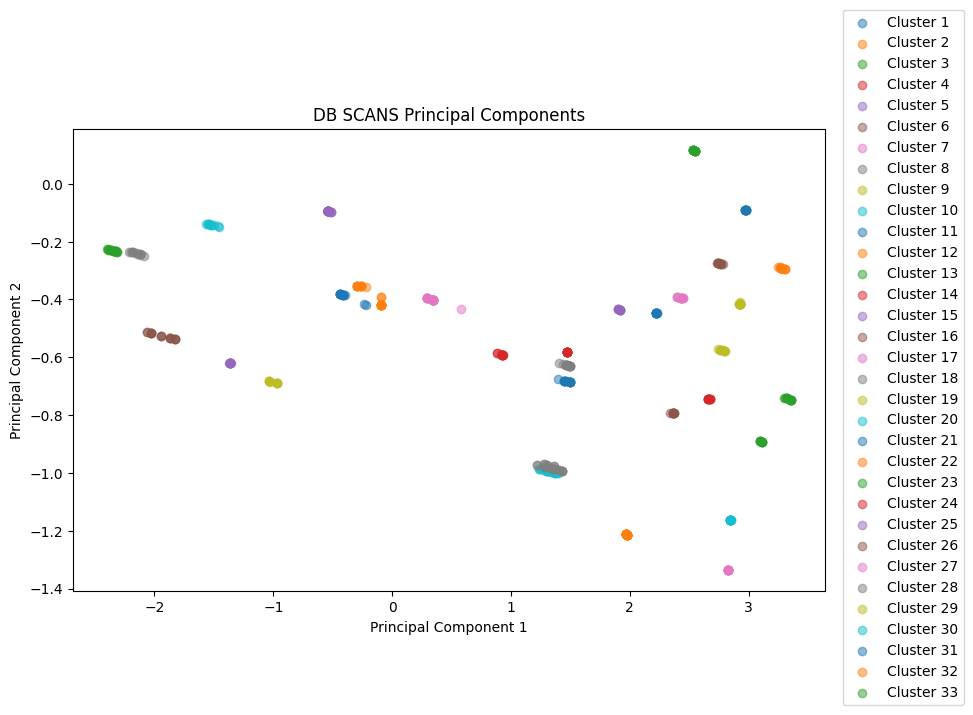

In [ ]:
# Plotting the two PC
# create the canvas for the plot
resolution = 100
figure_size = 6
fig = plt.figure(dpi=resolution, figsize=(figure_size * 1.618, figure_size))

# choose a color scheme
colors = plt.cm.tab10.colors
# plot the separated cluster
for j in range(np.max(dbs_labels)):
  plt.scatter(principal_dbs_Df[(principal_dbs_Df['CLUSTER']==j)].drop(['PC 2','CLUSTER'], axis=1).to_numpy(),
              principal_dbs_Df[(principal_dbs_Df['CLUSTER']==j)].drop(['PC 1','CLUSTER'], axis=1).to_numpy(),
              color=colors[j % len(colors) ], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('DB SCANS Principal Components')
fig.legend(["Cluster " + str(x+1) for x in range(np.max(dbs_labels))], loc='center right', bbox_to_anchor=(1.05, 0.5))
plt.show()

In [ ]:
# faccio KPCA
kpca = KernelPCA(n_components = 2, kernel = 'rbf', gamma = 15)
X_kpca = kpca.fit_transform(x)